# Analysis of Local Police Data

This notebook analyzes police data collected and standardized by The Trace and BuzzFeed News. Please see this repository's `README.md` file for more details.

# Load the data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
sns.set_style("whitegrid")

In [2]:
offenses = pd.read_csv(
    "../inputs/offenses-standardized.csv",
    low_memory = False
)

offenses.head()

,row_hash,source,agency_name,agency_ori,agency_incident_id,occurred_date,occurred_time,offense_category,top_ucr_classification,top_local_classification,...,victim_race,victim_ethnicity,victim_race_condensed,victim_sex,case_status,arrest_ind,clearance_status,clearance_group,clearance_date,arrest_date
0,MDBPD0000-C419771020-01-01,BALTIMORE-MAIN,BALTIMORE-PD,MDBPD0000,17V0351,2017-07-26,NaN,NON FATAL SHOOTING,NaN,NON FATAL SHOOTING,...,BLACK,NaN,BLACK/HISPANIC,MALE,OPEN,NaN,OPEN,Open & No Arrest-Unspecified,NaN,NaN
1,MDBPD0000-B63BECA76C-01-01,BALTIMORE-MAIN,BALTIMORE-PD,MDBPD0000,17H0198,2017-07-26,NaN,NON FATAL SHOOTING,NaN,NON FATAL SHOOTING,...,BLACK,NaN,BLACK/HISPANIC,FEMALE,OPEN,NaN,OPEN,Open & No Arrest-Unspecified,NaN,NaN
2,MDBPD0000-8A7079014F-01-01,BALTIMORE-MAIN,BALTIMORE-PD,MDBPD0000,17V0349,2017-07-25,NaN,NON FATAL SHOOTING,NaN,NON FATAL SHOOTING,...,BLACK,NaN,BLACK/HISPANIC,MALE,OPEN,NaN,OPEN,Open & No Arrest-Unspecified,NaN,NaN
3,MDBPD0000-3EF6B5EBEF-01-01,BALTIMORE-MAIN,BALTIMORE-PD,MDBPD0000,17V0348,2017-07-25,NaN,NON FATAL SHOOTING,NaN,NON FATAL SHOOTING,...,BLACK,NaN,BLACK/HISPANIC,MALE,OPEN,NaN,OPEN,Open & No Arrest-Unspecified,NaN,NaN
4,MDBPD0000-5995BFA411-01-01,BALTIMORE-MAIN,BALTIMORE-PD,MDBPD0000,17V0346,2017-07-24,NaN,NON FATAL SHOOTING,NaN,NON FATAL SHOOTING,...,BLACK,NaN,BLACK/HISPANIC,MALE,OPEN,NaN,OPEN,Open & No Arrest-Unspecified,NaN,NaN


In [3]:
len(offenses)

747419

In [4]:
offenses["offense_simple"] = offenses["offense_group"].apply(lambda x: x.split(" - ")[0])

In [5]:
offenses["year"] = offenses["occurred_date"].fillna("-1").str.slice(0, 4).astype(int)

In [6]:
offenses["agency_name"].nunique()

22

In [7]:
MAIN_OFFENSES = [
    "Homicide - Gun",
    "Homicide - Other Weapon",
    "Non-Fatal Shooting",
    "Agg Assault - Gun",
    "Agg Assault - Other Weapon",
]

In [8]:
MAIN_OFFENSES_PLUS_UNSPEC = MAIN_OFFENSES + [
    "Agg Assault - Weapon Unspecified",
    "Homicide - Weapon Unspecified",
]

In [9]:
GUN_OFFENSES = [
    "Homicide - Gun",
    "Non-Fatal Shooting",
    "Agg Assault - Gun",
]

# Examine clearance and offense categories

In [10]:
(
    offenses
    ["clearance_group"]
    .fillna("[blank]")
    .value_counts()
)

Open & No Arrest-Unspecified           444876
Cleared-Arrest & Arrest-Unspecified    231729
Cleared/Closed-Unspecified              39247
Cleared-Ex                              31322
Null, Missing, Unclear                    245
Name: clearance_group, dtype: int64

In [11]:
(
    offenses
    ["offense_group"]
    .fillna("[blank]")
    .value_counts()
)

Agg Assault - Other Weapon          424730
Agg Assault - Gun                   270146
Homicide - Gun                       25212
Agg Assault - Weapon Unspecified     11500
Non-Fatal Shooting                    8284
Homicide - Other Weapon               6975
Homicide - Weapon Unspecified          572
Name: offense_group, dtype: int64

# Convert offenses into incidents

In [12]:
offenses["incident_uid"] = (
    offenses
    [[
        "agency_ori",
        "offense_group",
        "agency_incident_id",
    ]]
    .apply("|".join, axis = 1)
)

In [13]:
clearance_group_hierarchy = [
    'Cleared-Arrest & Arrest-Unspecified',
    'Cleared-Ex',
    'Cleared/Closed-Unspecified',
    'Open & No Arrest-Unspecified',
    'Null, Missing, Unclear'
]

In [14]:
incidents = (
    offenses
    .assign(
        clearance_order = lambda df: df["clearance_group"].apply(clearance_group_hierarchy.index)
    )
    .sort_values([
        "incident_uid",
        "clearance_order",
        "arrest_date",
    ])
    .drop_duplicates(subset = [ "incident_uid" ])
    [[
        "incident_uid",
        "agency_name",
        "offense_group",
        "year",
        "occurred_date",
        "clearance_group",
        "arrest_date",
    ]]
)

In [15]:
incident_uids_with_arrest = (
    incidents
    .loc[lambda df: df["clearance_group"] == "Cleared-Arrest & Arrest-Unspecified"]
    ["incident_uid"]
)

len(incident_uids_with_arrest)

221005

# Identify main outcome metrics for each agency/offense combination

Primarily, we're looking to distinguish between `Cleared-Arrest & Arrest-Unspecified` agencies vs. `Cleared/Closed-Unspecified`.

In [16]:
agency_outcome_metrics = (
    offenses
    .groupby([
        "agency_name",
        "offense_group",
        "year",
    ])
    ["clearance_group"]
    .unique()
    .apply(sorted)
    .apply(lambda x: 
           "Cleared-Arrest & Arrest-Unspecified" if "Cleared-Arrest" in "|".join(x) 
           else "Cleared/Closed-Unspecified"
    )
    .to_frame("outcome_metric")
    .reset_index()
)

(
    agency_outcome_metrics
    .loc[lambda df: df["offense_group"].isin(GUN_OFFENSES)]
    .head()
)

,agency_name,offense_group,year,outcome_metric
0,BALTIMORE-PD,Homicide - Gun,2012,Cleared/Closed-Unspecified
1,BALTIMORE-PD,Homicide - Gun,2013,Cleared/Closed-Unspecified
2,BALTIMORE-PD,Homicide - Gun,2014,Cleared/Closed-Unspecified
3,BALTIMORE-PD,Homicide - Gun,2015,Cleared/Closed-Unspecified
4,BALTIMORE-PD,Homicide - Gun,2016,Cleared/Closed-Unspecified


Number of agencies with arrest information on gun offenses:

In [17]:
(
    agency_outcome_metrics
    .loc[lambda df: df["offense_group"].isin(GUN_OFFENSES)]
    .loc[lambda df: df["outcome_metric"] == "Cleared-Arrest & Arrest-Unspecified"]
    ["agency_name"]
    .nunique()
)

19

Broken down in more detail:

In [18]:
(
    agency_outcome_metrics
    .loc[lambda df: df["offense_group"].isin(GUN_OFFENSES)]
    .groupby([
        "offense_group",
        "outcome_metric"
    ])
   ["agency_name"]
    .nunique()
    .unstack()
)

outcome_metric,Cleared-Arrest & Arrest-Unspecified,Cleared/Closed-Unspecified
offense_group,,
Agg Assault - Gun,13,6
Homicide - Gun,18,10
Non-Fatal Shooting,3,4


#  Calculate arrest/closure rates, using the main outcomes identified above

In [19]:
def make_counts(df):
    return (
        df
        .loc[lambda df: df["year"] >= 2007]
        .loc[lambda df: df["year"] < 2017]
        .pipe(lambda df: (
            df
            .merge(
                agency_outcome_metrics,
                how = "left",
                on = [ "agency_name", "offense_group", "year" ],
                validate = "m:1"
            )
        ))
        .assign(outcome = lambda df: pd.np.where(
            (df["outcome_metric"] == "Cleared-Arrest & Arrest-Unspecified"),
            pd.np.where(
                df["clearance_group"].str.contains("Cleared-Arrest"),
                "Arrest",
                "No Arrest"
            ),
            pd.np.where(
                df["clearance_group"].str.contains("Cleared/Closed"),
                "Cleared/Closed",
                "Not Cleared/Closed"
            ),
        ))
        .groupby([
            "year",
            "agency_name",
            "offense_group",
            "outcome",
        ])
        .size()
        .to_frame("count")
        .reset_index()
    )


In [20]:
closure_counts = incidents.pipe(make_counts)

closure_counts.head()

,year,agency_name,offense_group,outcome,count
0,2007,BOSTON-PD,Homicide - Gun,Cleared/Closed,20
1,2007,BOSTON-PD,Homicide - Gun,Not Cleared/Closed,31
2,2007,BOSTON-PD,Homicide - Other Weapon,Cleared/Closed,12
3,2007,BOSTON-PD,Homicide - Other Weapon,Not Cleared/Closed,1
4,2007,CHICAGO-PD,Agg Assault - Gun,Arrest,920


In [21]:
closure_counts["outcome"].value_counts()

Arrest                605
No Arrest             571
Not Cleared/Closed    104
Cleared/Closed         81
Name: outcome, dtype: int64

In [22]:
closure_counts_wide = (
    closure_counts
    .pipe(lambda df: (
        df
        .merge(
            df
            .groupby([
                "agency_name",
                "year",
                "offense_group"
            ])
            ["count"]
            .sum()
            .to_frame("total")
            .reset_index(),
            how = "left",
            validate = "m:1"
        )
    ))
    .loc[lambda df: ~df["outcome"].str.contains(r"No")]
)

closure_counts_wide.head()

,year,agency_name,offense_group,outcome,count,total
0,2007,BOSTON-PD,Homicide - Gun,Cleared/Closed,20,51
2,2007,BOSTON-PD,Homicide - Other Weapon,Cleared/Closed,12,13
4,2007,CHICAGO-PD,Agg Assault - Gun,Arrest,920,4383
6,2007,CHICAGO-PD,Agg Assault - Other Weapon,Arrest,3263,12333
8,2007,CHICAGO-PD,Agg Assault - Weapon Unspecified,Arrest,65,166


In [23]:
closure_counts_wide["outcome"].value_counts()

Arrest            605
Cleared/Closed     81
Name: outcome, dtype: int64

In [24]:
arrest_rates_2013_16 = (
    closure_counts_wide
    .loc[lambda df: df["offense_group"].isin(MAIN_OFFENSES)]
    .loc[lambda df: df["year"].isin([ 2013, 2014, 2015, 2016 ])]
    .loc[lambda df: df["outcome"] == "Arrest"]
    .groupby([
        "agency_name",
        "offense_group",
    ])[[
        "count",
        "total",
    ]]
    .sum()
    .reset_index()
    .assign(arrest_rate = lambda df: df["count"] / df["total"])
    .set_index([
        "agency_name",
        "offense_group"
    ])
    ["arrest_rate"]
    .unstack()
    .reset_index()
    .set_index(["agency_name"])
    .sort_values(MAIN_OFFENSES, ascending = False)
    [MAIN_OFFENSES]
    .round(4)
)

arrest_rates_2013_16

offense_group,Homicide - Gun,Homicide - Other Weapon,Non-Fatal Shooting,Agg Assault - Gun,Agg Assault - Other Weapon
agency_name,,,,,
LAS-VEGAS-MPD,0.5941,0.8057,NaN,0.1508,0.2992
COLORADO-SPRINGS-PD,0.5686,0.8333,NaN,0.4947,0.6563
SAN-DIEGO-PD,0.5200,0.7708,NaN,0.2887,0.3979
DALLAS-PD,0.5000,0.6486,NaN,0.1253,0.1604
LOS-ANGELES-PD,0.4874,0.7363,NaN,0.1635,0.3245
LOUISVILLE-MPD,0.4781,0.7170,NaN,0.3178,0.6258
NEW-YORK-CITY-PD,0.4592,0.8021,NaN,NaN,NaN
HOUSTON-PD,0.4538,0.6307,NaN,NaN,NaN
PITTSBURGH-PD,0.4381,0.7826,NaN,0.2400,0.6891


# Houston closure analysis

In [25]:
houston_gun_assaults = (
    incidents
    .loc[lambda df: df["agency_name"] == "HOUSTON-PD"]
    .loc[lambda df: df["occurred_date"] < "2018-07"]
    .loc[lambda df: df["year"] >= 2010]
    .loc[lambda df: df["offense_group"] == "Agg Assault - Gun"]
    .assign(
        is_closed = lambda df: df["clearance_group"] == "Cleared/Closed-Unspecified"
    )    
)

len(houston_gun_assaults)

22521

In [26]:
(
    houston_gun_assaults
    ["clearance_group"]
    .value_counts()
)

Open & No Arrest-Unspecified    15988
Cleared/Closed-Unspecified       6531
Null, Missing, Unclear              2
Name: clearance_group, dtype: int64

In [27]:
(
    # Note: Above, we've limited 2018 to the first half of the year
    houston_gun_assaults
    .groupby("year")
    ["is_closed"]
    .mean()
    .round(3)
)

year
2010    0.384
2011    0.417
2012    0.382
2013    0.354
2014    0.371
2015    0.316
2016    0.197
2017    0.124
2018    0.087
Name: is_closed, dtype: float64

# Calculate outcome disparities by weapon type

In [28]:
def make_grouped_arrest_table(df, grouping):
    if not isinstance(grouping, list):
        grouping = [ grouping ]
    
    full_grouping = [ "agency_name", "offense_group" ] + grouping
    
    return (
        df
        .merge(
            agency_outcome_metrics,
            how = "left",
            on = [ "agency_name", "offense_group", "year" ],
            validate = "m:1"
        )
        .loc[lambda df: df["outcome_metric"] == "Cleared-Arrest & Arrest-Unspecified"]
        .drop(columns = [ "outcome_metric" ])        
        .assign(incident_has_arrest = lambda df: df["incident_uid"].isin(incident_uids_with_arrest))
        [[
            "incident_uid",
            "incident_has_arrest" 
        ] + full_grouping]
        .drop_duplicates()
        .groupby(full_grouping)
        
        .pipe(lambda grp: pd.DataFrame({
            "incidents_arrest": grp["incident_has_arrest"].sum(),
            "incidents_total": grp.size(),
        }))
        .astype(int)
        .assign(
            arrest_rate = lambda df: df["incidents_arrest"] / df["incidents_total"]
        )
        .reset_index()
    )

In [29]:
def aggregate_from_arrest_table(table):
    cols_to_group = [ c for c in table.columns if c not in [
        "agency_name",
        "offense_group",
        "incidents_total",
        "incidents_arrest",
        "arrest_rate"
    ]]
    
    return (
        table
        .groupby(cols_to_group)
        .pipe(lambda grp: pd.DataFrame({
            "incidents_total": grp["incidents_total"].sum(),
            "incidents_arrest": grp["incidents_arrest"].sum(),
        }))
        .assign(arrest_rate = lambda df: df["incidents_arrest"] / df["incidents_total"])
    )

In [30]:
def medians_from_arrest_table(table):
    cols_to_group = [ c for c in table.columns if c not in [
        "agency_name",
        "offense_group",
        "incidents_total",
        "incidents_arrest",
        "arrest_rate"
    ]]
    
    return (
        table
        .groupby(cols_to_group)
        .median()
    )

In [31]:
# Aggregates
(
    (
        offenses
        .loc[lambda df: df["firearm_ind"].isin([
            "Y",
            "N"
        ])]
        .loc[lambda df: df["occurred_date"] >= "2013"]
        .loc[lambda df: df["occurred_date"] < "2017"]
        .pipe(make_grouped_arrest_table, [ "offense_simple", "firearm_ind" ])
        .pipe(aggregate_from_arrest_table)
    )
    ["arrest_rate"]
    .unstack()
    .assign(ratio = lambda df: df["Y"] / df["N"])
    .reset_index()
    .sort_values("ratio")
)

firearm_ind,offense_simple,N,Y,ratio
1,Homicide,0.694318,0.368812,0.531186
0,Agg Assault,0.390221,0.230219,0.589971
2,Non-Fatal Shooting,NaN,0.204934,NaN


In [32]:
# Medians
(
    (
        offenses
        .loc[lambda df: df["firearm_ind"].isin([
            "Y",
            "N"
        ])]
        .loc[lambda df: df["occurred_date"] >= "2013"]
        .loc[lambda df: df["occurred_date"] < "2017"]
        .pipe(make_grouped_arrest_table, [ "offense_simple", "firearm_ind" ])
        
        .loc[lambda df: df["incidents_total"] >= 10]
        .set_index([
            "agency_name",
            "offense_simple",
            "firearm_ind"
        ])        
        ["arrest_rate"]
        .unstack()
        .assign(ratio = lambda df: df["Y"] / df["N"])
        .reset_index()
        .sort_values("ratio")
        .dropna()
        .groupby([ "offense_simple" ])
        .median()
    )
)

firearm_ind,N,Y,ratio
offense_simple,,,
Agg Assault,0.465999,0.240089,0.542364
Homicide,0.755682,0.438144,0.578102


# Calculate arrest disparities by race/ethnicity

## Median disparities, 2007–16

In [33]:
def calculate_arrest_rates_by_race(year_start, year_end):
    return (
        offenses
        .loc[lambda df: df["offense_group"].isin(MAIN_OFFENSES)]
        .loc[lambda df: df["year"] >= year_start]
        .loc[lambda df: df["year"] <= year_end]
        .loc[lambda df: df["victim_race_condensed"].isin([
            "BLACK/HISPANIC",
            "WHITE"
        ])]
        .pipe(lambda df: (
            df
            .groupby([
                "agency_name",
                "offense_simple",
                "offense_group",
                "victim_race_condensed",
                "clearance_group",
            ])
            .pipe(lambda grp: (
                grp
                ["agency_incident_id"]
                .nunique()
                .to_frame("outcome_count")
                .reset_index()
            ))
            .merge(
                df
                .groupby([
                    "agency_name",
                    "offense_group",
                    "victim_race_condensed",
                ])
                .pipe(lambda grp: (
                    grp
                    ["agency_incident_id"]
                    .nunique()
                    .to_frame("incident_count")
                    .reset_index()
                )),
                how = "left",
                validate = "m:1"
            )       
        ))
        .loc[lambda df: df["clearance_group"] == "Cleared-Arrest & Arrest-Unspecified"]
        .assign(
            arrest_rate = lambda df: df["outcome_count"] / df["incident_count"]
        )
        .drop(columns = [ "clearance_group" ])
    )

In [34]:
arrest_rates_by_race_2007_16 = (
    offenses
    .loc[lambda df: df["offense_group"].isin(MAIN_OFFENSES)]
    .loc[lambda df: df["year"] >= 2007]
    .loc[lambda df: df["year"] <= 2016]
    .loc[lambda df: df["victim_race_condensed"].isin([
        "BLACK/HISPANIC",
        "WHITE"
    ])]    
    .pipe(make_grouped_arrest_table, [ "offense_simple", "victim_race_condensed" ])
)

arrest_rates_by_race_2007_16.head()

,agency_name,offense_group,offense_simple,victim_race_condensed,incidents_arrest,incidents_total,arrest_rate
0,BOSTON-PD,Homicide - Gun,Homicide,BLACK/HISPANIC,47,125,0.376000
1,BOSTON-PD,Homicide - Gun,Homicide,WHITE,3,6,0.500000
2,BOSTON-PD,Homicide - Other Weapon,Homicide,BLACK/HISPANIC,22,39,0.564103
3,BOSTON-PD,Homicide - Other Weapon,Homicide,WHITE,13,18,0.722222
4,BOSTON-PD,Non-Fatal Shooting,Non-Fatal Shooting,BLACK/HISPANIC,12,134,0.089552


### Use only agency-offense combinations with 20+ incidents involving both main `victim_race_condensed` categories, for both the firearm and non-firearm versions of a given offense

In [35]:
agencies_for_median_chart = (
    arrest_rates_by_race_2007_16
    .loc[lambda df: df["incidents_total"] >= 20]
    .pipe(lambda df: (
        df
        .groupby([
            "agency_name",
            "offense_simple"
        ])
        .size()
        .loc[lambda x: x == 4]
        .to_frame("count")
        .reset_index()
        .merge(
            df,
            how = "left"
        )
    ))
)

agencies_for_median_chart.head()

,agency_name,offense_simple,count,offense_group,victim_race_condensed,incidents_arrest,incidents_total,arrest_rate
0,CHICAGO-PD,Homicide,4,Homicide - Gun,BLACK/HISPANIC,854,3765,0.226826
1,CHICAGO-PD,Homicide,4,Homicide - Gun,WHITE,38,122,0.311475
2,CHICAGO-PD,Homicide,4,Homicide - Other Weapon,BLACK/HISPANIC,364,645,0.564341
3,CHICAGO-PD,Homicide,4,Homicide - Other Weapon,WHITE,58,102,0.568627
4,COLORADO-SPRINGS-PD,Agg Assault,4,Agg Assault - Gun,BLACK/HISPANIC,247,514,0.480545


In [36]:
disparities_for_median_chart = (
    agencies_for_median_chart
    .set_index([
        "agency_name",
        "offense_group",
        "victim_race_condensed",
    ])
    ["arrest_rate"]
    .unstack()
    .assign(
        diff = lambda df: df["WHITE"] - df["BLACK/HISPANIC"]
    )
    .reset_index()
)

disparities_for_median_chart.head()

victim_race_condensed,agency_name,offense_group,BLACK/HISPANIC,WHITE,diff
0,CHICAGO-PD,Homicide - Gun,0.226826,0.311475,0.084649
1,CHICAGO-PD,Homicide - Other Weapon,0.564341,0.568627,0.004286
2,COLORADO-SPRINGS-PD,Agg Assault - Gun,0.480545,0.510507,0.029962
3,COLORADO-SPRINGS-PD,Agg Assault - Other Weapon,0.655355,0.655122,-0.000233
4,DALLAS-PD,Agg Assault - Gun,0.124750,0.141264,0.016513


### Median disparities by offense/weapon group

In [37]:
(
    disparities_for_median_chart
    .groupby("offense_group")
    .pipe(lambda grp: pd.DataFrame({
        "median_diff": grp["diff"].median(),
        "agency_count": grp["agency_name"].nunique()
    }))
)

,median_diff,agency_count
offense_group,,
Agg Assault - Gun,0.062950,5
Agg Assault - Other Weapon,0.009745,5
Homicide - Gun,0.121223,10
Homicide - Other Weapon,0.001151,10


### Make chart

In [38]:
def tee(df, fn, *args, **kwargs):
    fn(df, *args, **kwargs)
    return df

In [39]:
def percentify_axes(ax, lim = (0, 1), name = "y"):
    axis = getattr(ax, name + "axis")
    axis.set_ticks(pd.np.arange(0, 1.1, 0.1 * lim[1]))
    axis.set_ticklabels([ "{:.0f}%".format(y * 100)
        for y in getattr(ax, "get_{}ticks".format(name))() ])
    
    getattr(ax, "set_{}lim".format(name))(*lim)
    return ax

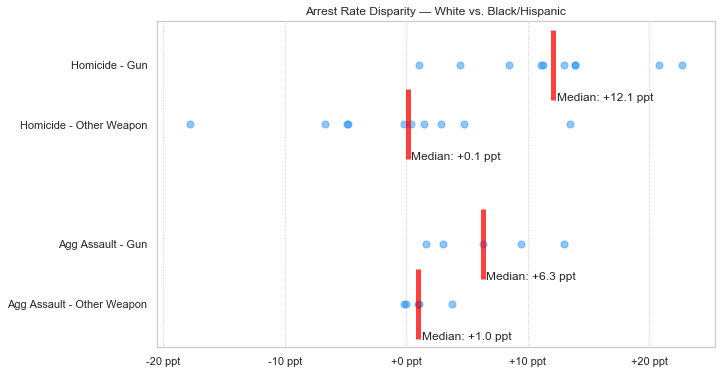

In [40]:
fig, axs = plt.subplots(
    nrows = 1,
    figsize = (10, 6),
)
(
    disparities_for_median_chart
    .assign(
        diff = lambda df: df["diff"]
    )
    .assign(
        offense_index = lambda df: df["offense_group"].replace({
            "Homicide - Gun": 0,
            "Homicide - Other Weapon": 1,
            "Agg Assault - Gun": 3,
            "Agg Assault - Other Weapon": 4
        })
    )
    .pipe(tee, lambda df: axs.scatter(
        df["diff"],
        df["offense_index"],
        color = "dodgerblue",
        alpha = 0.5,
        s = 50,
    ))
    .pipe(tee, lambda df: (
        df
        .groupby("offense_index")
        ["diff"]
        .median()
        .pipe(tee, lambda x: axs.scatter(
            x,
            x.index,
            lw = 5,
            marker = "|",
            s = 5000,
            color = "red",
            alpha = 0.75,
        ))
        .pipe(tee, lambda xs: [ axs.annotate(
            f"Median: {(x * 100):+.1f} ppt",
            (x + 0.003, i + 0.6),
            fontsize = 12
        ) for i, x in xs.iteritems() ])
        .pipe(tee, lambda x: axs.set_yticks(x.index)) 
    ))    
)

axs.set_yticklabels([
    "Homicide - Gun",
    "Homicide - Other Weapon",
    "Agg Assault - Gun",
    "Agg Assault - Other Weapon",
])
axs.xaxis.grid(linestyle = "dotted")
# axs.axvline(0, color = "black", lw = 1, zorder = -1)
axs.invert_yaxis()
axs.yaxis.grid(False)
axs.set_title("Arrest Rate Disparity — White vs. Black/Hispanic")
axs.set_xticklabels([ f"{(x * 100):+.0f} ppt" for x in axs.get_xticks() ])
    
pass

# Calculate aggregate arrest disparities by offense and victim race

In [41]:
def calculate_aggregate_disparity(offenses_df, start_year, end_year):
    return (
        offenses_df
        .loc[lambda df: df["year"] >= start_year]
        .loc[lambda df: df["year"] <= end_year]
        .loc[lambda df: df["victim_race_condensed"].isin([
            "BLACK/HISPANIC",
            "WHITE"
        ])]    
        .pipe(tee, lambda df: print(f"{df['agency_name'].nunique()} agencies"))
        .pipe(make_grouped_arrest_table, [ "victim_race_condensed" ])
        .groupby([ "offense_group", "victim_race_condensed" ])
        .pipe(lambda grp: pd.DataFrame({
            "incidents_total": grp["incidents_total"].sum(),
            "incidents_arrest": grp["incidents_arrest"].sum(),
        }))
        .assign(arrest_rate = lambda df: df["incidents_arrest"] / df["incidents_total"])        
        ["arrest_rate"]
        .unstack()
        .assign(diff = lambda df: df["BLACK/HISPANIC"] - df["WHITE"])
        .sort_values("diff")    
    )

In [42]:
(
    calculate_aggregate_disparity(offenses, 2013, 2016)
    .loc[MAIN_OFFENSES]
)

18 agencies


victim_race_condensed,BLACK/HISPANIC,WHITE,diff
offense_group,,,
Homicide - Gun,0.345220,0.521484,-0.176264
Homicide - Other Weapon,0.665714,0.709184,-0.043469
Non-Fatal Shooting,0.130112,0.223684,-0.093573
Agg Assault - Gun,0.211037,0.366019,-0.154981
Agg Assault - Other Weapon,0.351628,0.440837,-0.089209


---

---

---